# Demo of F3DASM

We are going to take a look at the different functionalities:
* Create a design of experiments
* Sample from this space
* Evaluate the samples using a well-known benchmark function
* Iteratively find the minimum of the loss-landscape using a global optimizer
* Look at one of the example experiments: 20D Ackley optimization with CMAES

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width: 100% !important}</style>'))

/tmp/ipykernel_77364/3593773758.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


import the `f3dasm` package, and `numpy`:

In [2]:
import f3dasm
import numpy as np

make sure that we specify a `seed`:

In [3]:
seed = 42

### Design: Creating the design space

Define the parameters $x_0$, $x_1$ and the output $y$
We add a `lower_bound` and an `upper_bound` to define the box-constraints:

In [4]:
# Input parameters
x1 = f3dasm.ContinuousParameter(name="x0", lower_bound=-1., upper_bound=1.)
x2 = f3dasm.ContinuousParameter(name="x1", lower_bound=-1., upper_bound=1.)

and an output parameter `y` that is continuous and not constraint:

In [5]:
# Output parameters
y = f3dasm.ContinuousParameter(name="y")

We construct 2 lists of these parameters and the designspace: 

In [6]:
# Create lists of parameters
input_space = [x1, x2]
output_space = [y]

And the design space with the `f3dasm.DesignSpace` class

In [7]:
# Construct the design space
design_manually = f3dasm.DesignSpace(input_space=input_space, output_space=output_space)

I have created a helper function that makes it easier to construct a n-dimensional continuous, single-objective space:

In [8]:
dim = 2
domain = np.tile([-1., 1.], (dim,1))
design = f3dasm.make_nd_continuous_design(bounds=domain, dimensionality=dim)

# Check if they are equal
assert design_manually == design

What's next? We can sample from this design space with the **sampling** block!

### Sampling: Latin Hypercube Sampler

To sample from the design space, we need a sampler. We choose the `LatinHypercubeSampling` sampler:

In [9]:
# Construct sampler
samples = f3dasm.sampling.LatinHypercubeSampling(design=design, seed=seed)

By invoking the `get_samples()` method, we obtain samples according to the sampling strategy:

In [10]:
N = 30 # Number of samples

data = samples.get_samples(numsamples=N)

In [11]:
data

Data(design=DesignSpace(input_space=[ContinuousParameter(name='x0', lower_bound=-1.0, upper_bound=1.0, type='float'), ContinuousParameter(name='x1', lower_bound=-1.0, upper_bound=1.0, type='float')], output_space=[ContinuousParameter(name='y', lower_bound=-inf, upper_bound=inf, type='float')]), data=       input           output
          x0        x1      y
0   0.220308 -0.324034    NaN
1  -0.796128  0.568005    NaN
2  -0.665294 -0.742255    NaN
3  -0.884534  0.187226    NaN
4  -0.693259  0.206511    NaN
5  -0.371204 -0.147655    NaN
6   0.731306 -0.602006    NaN
7   0.839860  0.792988    NaN
8   0.936348  0.879732    NaN
9  -0.120022 -0.380585    NaN
10  0.071003 -0.099051    NaN
11 -0.856265  0.460621    NaN
12 -0.292543 -0.063570    NaN
13  0.402293  0.366345    NaN
14 -0.521212  0.129926    NaN
15 -0.247190  0.510835    NaN
16  0.312282  0.296010    NaN
17  0.483919  0.718342    NaN
18 -0.544504  0.612324    NaN
19 -0.975031 -0.856267    NaN
20  0.636447 -0.686128    NaN
21  0.795

We can plot the datapoints with the `data.plot()` function:

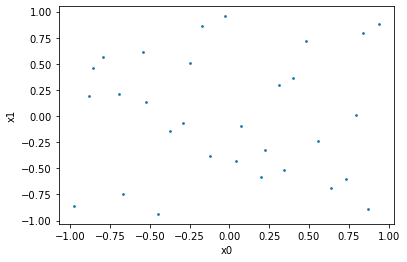

In [12]:
data.plot(input_par1='x0', input_par2='x1')

As you could see earlier, the output values are all `NaN`. Let's evaluate the samples with the **simulation** block!

### Simulation: Evaluating a benchmark function

Several benchmark function have been implemented to work with **continuous and single-objective** optimization problems.

These functions require an input-vector $\mathbf{x}$ and output a scalar $f(\mathbf{x})$

The `Levy()` function is a well-known, multimodal function:

$f(\textbf{x}) = \sin^2 (\pi w_1) + \sum_{i = 1}^{D - 1} (w_i - 1)^2 \left( 1 + 10 \sin^2 (\pi w_i + 1) \right) + (w_d - 1)^2 (1 + \sin^2 (2 \pi w_d)) \\ w_i = 1 + \frac{x_i - 1}{4}`
$


First we create such a function by creating an object from the `f3dasm.functions.Levy` class

*The original input domain is (-10, 10), but we scale these boundaries to the boundaries our input space*

In [13]:
f = f3dasm.functions.Levy(dimensionality=dim, seed=seed, scale_bounds=domain)

The global minima are known for these functions:

In [14]:
x_min, y_min = f.get_global_minimum(dim)
print(f"The global minimum is {y_min} at position {x_min}")

The global minimum is [[1.49975978e-32]] at position [0.1 0.1]


We can plot a three-dimensional represtation of two input parameters $x_1$ and $x_2$ with the `plot()` function

(<Figure size 504x504 with 1 Axes>,
 <Axes3DSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>)

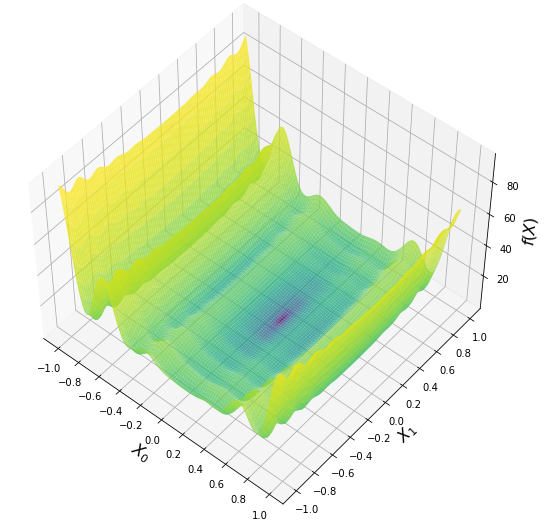

In [15]:
f.plot(px=100, domain=domain)

Evaluating the function is easy, just pass either:
* the `Data()` object to it: `data.get_input_data()`
* or a 2D numpy array: `data.get_input_data().to_numpy()`

.. and all the samples will be evaluated.
The output will be a `np.ndarray`

In [16]:
x = data.get_input_data()

By calling the `add_output` option, we can add individual columns or overwrite data to our DataFrame:

In [17]:
data.add_output(output=f(x))

In [18]:
data.show()

       input               output
          x0        x1          y
0   0.220308 -0.324034   2.807559
1  -0.796128  0.568005  10.862077
2  -0.665294 -0.742255  43.294078
3  -0.884534  0.187226  18.566415
4  -0.693259  0.206511  33.768357
5  -0.371204 -0.147655   4.755916
6   0.731306 -0.602006  12.127293
7   0.839860  0.792988  18.268522
8   0.936348  0.879732  48.877373
9  -0.120022 -0.380585   5.374564
10  0.071003 -0.099051   0.329502
11 -0.856265  0.460621  10.590401
12 -0.292543 -0.063570   8.499906
13  0.402293  0.366345   2.130571
14 -0.521212  0.129926  14.294572
15 -0.247190  0.510835   9.352832
16  0.312282  0.296010   2.101001
17  0.483919  0.718342   8.934938
18 -0.544504  0.612324  23.140543
19 -0.975031 -0.856267  76.644567
20  0.636447 -0.686128  20.451381
21  0.795967  0.011368   4.657333
22 -0.446384 -0.936619  11.817504
23  0.872566 -0.893423  28.629370
24  0.554114 -0.242243  15.262037
25  0.341469 -0.521106   4.143143
26 -0.027172  0.955022   8.020731
27  0.197709 -

We can create a contour plot with the samples coordinates with the `f.plot_data()` function: 

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>)

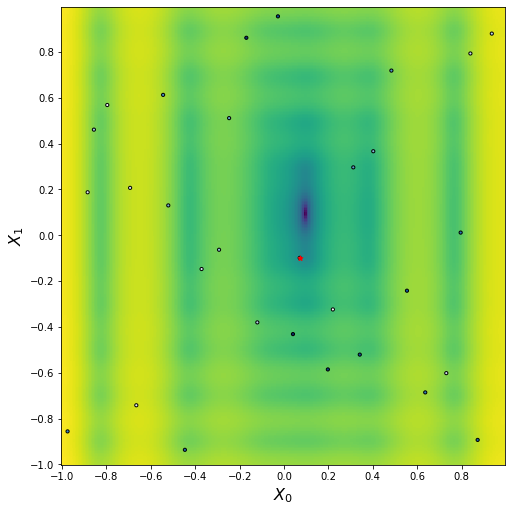

In [19]:
f.plot_data(data,px=300,domain=domain)

*The red start will indicate the best sample*

Now we will take a look how we can find the minimum of this loss-function with an optimizer!

### Optimization: CMAES optimizer

We will use the CMAES optimizer to find the minimum. We can find an implementation in the `f3dasm.optimization` module:

In [20]:
optimizer = f3dasm.optimization.CMAES(data=data)

By calling the `iterate()` method and specifying the function and the number of iterations, we will start the optimization process:

In [21]:
optimizer.iterate(iterations=20, function=f)

After that, we can extract the data:

In [22]:
cmaes_data = optimizer.extract_data()

... and create a contour plot again:

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>)

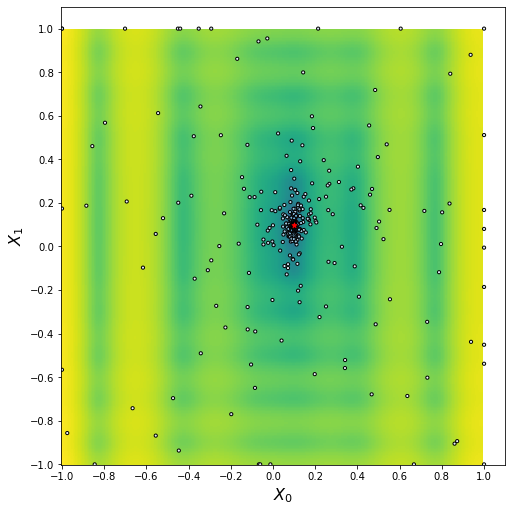

In [23]:
f.plot_data(data=cmaes_data,px=300, domain=domain)

### Experiment: Multiple realizations of SGA on 20D Ackley function

Now we take a look at an example of an experiment where use the following blocks to optimize a 20D Ackley function with the CMAES optimizer over 10 different realizations:

![title](blocks.png)

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
# Define the blocks:
dimensionality = 20
iterations = 20
realizations = 10

hyperparameters= {} # If none are selected, the default ones are used

domain = np.tile([-1., 1.], (dimensionality,1))
design = f3dasm.make_nd_continuous_design(bounds=domain, dimensionality=dimensionality)
data = f3dasm.Data(design)

In [26]:
# We can put them in a dictionary if we want

implementation = {
'realizations': realizations,
'optimizer': f3dasm.optimization.CMAES(data=data, hyperparameters=hyperparameters), 
'function': f3dasm.functions.Ackley(dimensionality=dimensionality, noise=False, scale_bounds=domain),
'sampler': f3dasm.sampling.LatinHypercubeSampling(design, seed=seed),
'iterations': iterations,
}

The `run_multiple_realizations()` function will be the pipeline of this experiment:

In [27]:
results = f3dasm.run_multiple_realizations(**implementation)

In [28]:
results[3].data

input                                                              \
           x0        x1        x2        x3        x4        x5        x6   
0    0.949704 -0.149221  0.599481 -0.161781 -0.013120  0.122241  0.449588   
1    0.097140  0.475435 -0.917995 -0.502515  0.666050 -0.088709  0.263792   
2    0.276776 -0.382584 -0.822561 -0.582001 -0.317785  0.960062 -0.239956   
3    0.188570 -0.216267 -0.513057 -0.971060 -0.426555 -0.317693  0.080902   
4    0.363232  0.883036  0.163720 -0.889204 -0.902510 -0.700102 -0.743564   
..        ...       ...       ...       ...       ...       ...       ...   
625 -0.317660 -0.311801 -0.446761 -0.007214 -0.008904  0.507137  0.189404   
626 -0.569752 -0.317619 -0.204308  0.030557  0.058828 -0.065040 -0.172376   
627 -0.089074 -0.271957 -0.007495 -0.075996 -0.267777  0.286049 -0.126648   
628  0.062640  0.001016 -0.243148 -0.313763  0.393181 -0.035026 -0.204001   
629  0.013747 -0.178667  0.018640  0.053692  0.332018  0.127868  0.286955   

                                   ...                                \
           x7        x8        x9  ...       x11       x12       x13   
0    0.552953 -0.551002 -0.776597  ... -0.479003  0.760577 -0.638485   
1   -0.915666  0.938368  0.528831  ... -0.775070  0.201000  0.083965   
2    0.641389  0.911708  0.886483  ...  0.673429 -0.540974 -0.241804   
3    0.232204 -0.653988  0.322255  ... -0.600590 -0.604559 -0.306074   
4   -0.497614 -0.349056  0.694482  ... -0.258901 -0.487814 -0.879183   
..        ...       ...       ...  ...       ...       ...       ...   
625  0.314394  0.464222  0.197890  ...  0.126629  0.029196 -0.054622   
626  0.353323  0.491324 -0.035936  ... -0.032789  0.062780 -0.184016   
627  0.371932 -0.161424  0.070081  ...  0.035054  0.261902  0.160668   
628  0.007893  0.793668 -0.106064  ... -0.677499 -0.116113  0.201151   
629  0.180434  0.133694 -0.063909  ...  0.167732  0.090731 -0.012322   

                                                                    output  
          x14       x15       x16       x17       x18       x19          y  
0   -0.771475 -0.521269 -0.210161 -0.793049 -0.913733 -0.266929  21.452731  
1   -0.320784  0.621756 -0.598605 -0.118093  0.639548 -0.944345  21.102406  
2   -0.423580  0.818702 -0.610536  0.288734  0.761406 -0.469819  21.510374  
3    0.086021 -0.314274 -0.079384 -0.477978  0.249254  0.265159  20.656717  
4    0.379784  0.737034  0.799672  0.428714 -0.687076  0.417031  21.356264  
..        ...       ...       ...       ...       ...       ...        ...  
625 -0.282620 -0.209728  0.164364  0.021674  0.110476  0.224720  18.167002  
626 -0.180448  0.069345  0.343233  0.273542  0.179934 -0.552264  17.916405  
627 -0.122078 -0.389083  0.157583  0.259435  0.129584 -0.579771  17.314712  
628 -0.636429 -0.147728  0.045510 -0.120291  0.329986 -0.235871  19.460859  
629 -0.410717 -0.065618 -0.060446  0.249311 -0.019441  0.204795  15.169071  

[630 rows x 21 columns]

In [29]:
def plot_results(results):
    mean_y = pd.concat([d.get_output_data() for d in results], axis=1).mean(axis=1)
    std_y = pd.concat([d.get_output_data() for d in results], axis=1).std(axis=1)
    
    fig, ax = plt.figure(), plt.axes()
    ax.plot(mean_y)
    ax.set_xlabel('iterations')
    ax.set_ylabel('f(x)')
    ax.fill_between(np.arange(len(mean_y)), mean_y-1.96*std_y, mean_y+1.96*std_y, color='b', alpha=.1)
    #ax.set_yscale('log')
    fig.show()

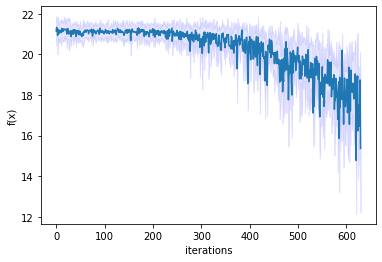

In [30]:
plot_results(results)

We can change a hyper-parameter such as the `population` and rerun the experiment with ease:

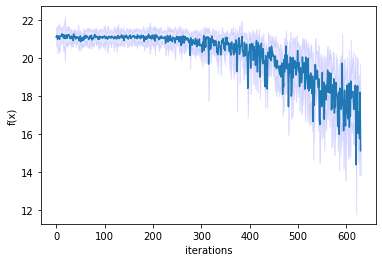

In [31]:
sga_2 = f3dasm.optimization.CMAES(data=data, hyperparameters={'population': 60})

implementation.update()
results_2 = f3dasm.run_multiple_realizations(**implementation)

plot_results(results_2)

In [32]:
implementation2 = {
'realizations': realizations,
'optimizer': f3dasm.optimization.PSO(data=data), 
'function': f3dasm.functions.Levy(dimensionality=dimensionality, noise=False, scale_bounds=domain),
'sampler': f3dasm.sampling.SobolSequenceSampling(design, seed=seed),
'iterations': iterations,
}

results_3 = f3dasm.run_multiple_realizations(**implementation2)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>)

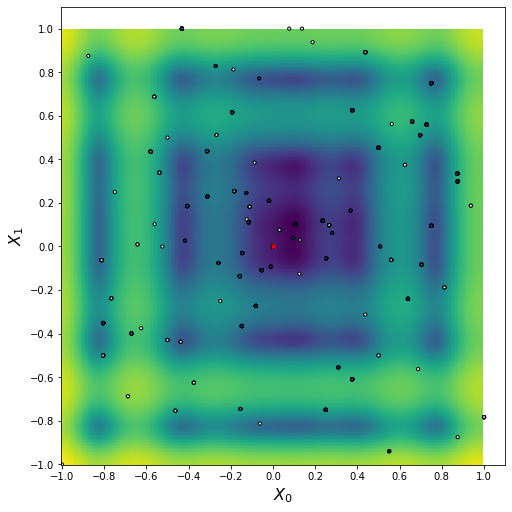

In [34]:
implementation2['function'].plot_data(data=results_3[0], domain=domain, px=300)